**1. IMPORTING LIBRARIES**

In [1]:
import vec2text
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
import numpy as np
import warnings

# Sopprimiamo i warning
warnings.filterwarnings("ignore")


**2. FUNCTIONS TO OBTAIN EMBEDDING E QUANTIZATIONS**

In [25]:
# Function to obtain embeddings using a GTR
def get_gtr_embeddings(text_list, encoder, tokenizer):
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding="max_length"
    ).to("cuda")

    with torch.no_grad():
        model_output = encoder(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        hidden_state = model_output.last_hidden_state
        embeddings = vec2text.models.model_utils.mean_pool(hidden_state, inputs['attention_mask'])

    return embeddings

# Function to quantize embeddings (adapted for list of embeddings)
def quantize_embeddings_list(embeddings_list, bits=8):
    quantized_embeddings_list = []
    embeddings_min_list = []
    embeddings_max_list = []

    for embeddings in embeddings_list:
        quantized, embeddings_min, embeddings_max = quantize_embeddings(embeddings, bits=bits)
        quantized_embeddings_list.append(quantized)
        embeddings_min_list.append(embeddings_min)
        embeddings_max_list.append(embeddings_max)

    return quantized_embeddings_list, embeddings_min_list, embeddings_max_list

# Function to dequantize embeddings (adapted for list of embeddings)
def dequantize_embeddings_list(quantized_embeddings_list, embeddings_min_list, embeddings_max_list, bits=8):
    dequantized_embeddings_list = []

    for quantized, embeddings_min, embeddings_max in zip(quantized_embeddings_list, embeddings_min_list, embeddings_max_list):
        dequantized = dequantize_embeddings(quantized, embeddings_min, embeddings_max, bits=bits)
        dequantized_embeddings_list.append(dequantized)

    return dequantized_embeddings_list

# Function to quantize embeddings
def quantize_embeddings(embeddings, bits=8):
    scale = 2 ** bits - 1
    embeddings_min = embeddings.min(dim=-1, keepdim=True).values
    embeddings_max = embeddings.max(dim=-1, keepdim=True).values
    quantized = ((embeddings - embeddings_min) / (embeddings_max - embeddings_min)) * scale
    quantized = quantized.round().to(torch.uint8)  # Convertiamo a uint8
    return quantized, embeddings_min, embeddings_max

# Function to dequantize embeddings
def dequantize_embeddings(quantized, embeddings_min, embeddings_max, bits=8):
    scale = 2 ** bits - 1
    quantized = quantized.to(torch.float32)  # Convertiamo a float32 per operazioni
    dequantized = (quantized / scale) * (embeddings_max - embeddings_min) + embeddings_min
    return dequantized

# Function to calculate the compression percentage
def calculate_compression_percentage(original_embeddings, quantized_embeddings):
    original_size = original_embeddings.numel() * original_embeddings.element_size()
    quantized_size = quantized_embeddings.numel() * quantized_embeddings.element_size()
    compression_ratio = (original_size - quantized_size) / original_size * 100
    return compression_ratio

**3. LOAD THE MODELS**

In [26]:
encoder = AutoModel.from_pretrained("sentence-transformers/gtr-t5-base").encoder.to("cuda")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/gtr-t5-base")
corrector = vec2text.load_pretrained_corrector("gtr-base")

Some weights of T5Model were not initialized from the model checkpoint at sentence-transformers/gtr-t5-base and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.weig

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

**4. TEXTS AND EMBEDDINGS**

In [65]:
# Sentence to convert into embeddings
text = [
    "The quick brown fox jumps over the lazy dog.",
    "In 2023, the price of a gallon of milk is approximately $3.50.",
    "Can you believe that the Eiffel Tower was completed in 1889?",
    "The sun rises in the east and sets in the west.",
    "I have 2 apples and 3 oranges in my basket.",
    "Artificial intelligence is a rapidly growing field.",
    "On a clear day, you can see up to 100 miles from the mountaintop.",
    "What time does the train to New York depart?",
    "The Pythagorean theorem states that in a right-angled triangle, a^2 + b^2 = c^2.",
    "There are seven continents on Earth: Africa, Antarctica, Asia, Europe, North America, Australia, and South America.",
    "Is the capital of Australia Sydney or Canberra?",
    "The recipe calls for 250 grams of flour and 100 grams of sugar.",
    "NASA's Perseverance rover is exploring Mars.",
    "The stock market can be volatile and unpredictable.",
    "The Great Wall of China stretches over 13,000 miles.",
    "Do you prefer coffee or tea in the morning?",
    "The human brain has approximately 86 billion neurons.",
    "In 1492, Christopher Columbus sailed the ocean blue.",
    "The smartphone you're using likely has more computing power than the computers used to land Apollo 11 on the Moon.",
    "A hexagon has six sides.",
    "The Mona Lisa was painted by Leonardo da Vinci.",
    "Did you know that honey never spoils?",
    "The speed of light is approximately 299,792 kilometers per second.",
    "My favorite number is 7 because it is considered lucky in many cultures.",
    "The average temperature in the Sahara Desert can exceed 50°C (122°F).",
    "Your package will arrive between 9:00 AM and 5:00 PM.",
    "Shakespeare wrote 'Romeo and Juliet' and 'Hamlet'.",
    "Do you have a moment to discuss this week's meeting agenda?",
    "The human body is made up of approximately 60% water.",
    "The periodic table consists of elements like hydrogen, helium, and carbon.",
    "Is it true that elephants are the largest land animals?",
    "The Internet was invented in the late 1960s and early 1970s.",
    "The capital city of France is Paris.",
    "In 2020, the global population was estimated to be around 7.8 billion.",
    "A kilogram is equal to 1000 grams.",
    "Do you know how to solve a quadratic equation?",
    "The moon orbits around the Earth approximately once every 27.3 days.",
    "Photosynthesis is the process by which plants make their own food using sunlight.",
    "Mount Everest is the highest peak in the world, reaching 8,848 meters above sea level.",
    "How many days are there in a leap year?",
    "The original Star Wars film was released in 1977.",
    "The first human landed on the Moon on July 20, 1969.",
    "Can you calculate the area of a circle if you know its radius?",
    "The Pacific Ocean is the largest and deepest ocean on Earth.",
    "Cats typically sleep between 12 and 16 hours a day.",
    "The longest river in the world is the Nile River.",
    "My birthday is on December 25th, which is also Christmas Day.",
    "Quantum mechanics deals with the behavior of particles at the atomic and subatomic levels.",
    "The Amazon Rainforest is known as the 'lungs of the Earth'.",
    "Do you know the difference between weather and climate?",
    "The chemical symbol for gold is Au.",
    "The Titanic sank on its maiden voyage in 1912.",
    "In binary code, the number 5 is represented as 101."
]


# Get embeddings from the sentences
embeddings = get_gtr_embeddings(text, encoder, tokenizer)


**5. EXECUTION OF THE OPERATIONS**

In [66]:
q_levels = [2, 4, 6, 8, 10, 12]
all_texts = []

for lv in q_levels:
    # Apply quantization and dequantization for each bit level
    quantized_embeddings_list, embeddings_min_list, embeddings_max_list = quantize_embeddings_list(embeddings, bits=lv)
    dequantized_embeddings_list = dequantize_embeddings_list(quantized_embeddings_list, embeddings_min_list, embeddings_max_list, bits=lv)

    inverted_texts = []
    for dequantized_embeddings in dequantized_embeddings_list:
        # Gestione basata sul numero di dimensioni
        if dequantized_embeddings.dim() == 3:
            # Se è 3D, media lungo la dimensione della sequenza
            dequantized_embeddings_mean = dequantized_embeddings.mean(dim=1)
        elif dequantized_embeddings.dim() == 2:
            # Se è 2D, non c'è bisogno di mediare
            dequantized_embeddings_mean = dequantized_embeddings
        elif dequantized_embeddings.dim() == 1:
            # Se è 1D, aggiungi una dimensione fittizia per l'inversione
            dequantized_embeddings_mean = dequantized_embeddings.unsqueeze(0)
        
        # Sposta su GPU
        dequantized_embeddings_mean = dequantized_embeddings_mean.cuda()

        # Invert the quantized embeddings to reconstruct the text
        inverted_text = vec2text.invert_embeddings(
            embeddings=dequantized_embeddings_mean,
            corrector=corrector,
            num_steps=20,
            sequence_beam_width=4
        )
        inverted_texts.append(inverted_text)
    
    all_texts.append(inverted_texts)


**6. RESULTS**

In [67]:
i = 2  # Initial level of quantization
for original in text:
    print(f"Original: {original}\n")
    for seq in all_texts:
        # Find the index on the original sentence
        original_idx = text.index(original)
        
        # Extract the corresponding quantized sentence
        inverted = seq[original_idx]
        orig_emb = embeddings[original_idx]
        quant_emb = quantized_embeddings_list[original_idx]
    
        print(f"RESULTS WITH {i} BIT QUANTIZATION: \n")
        print(f"Quantized: {inverted}\n")
        
        i += 2  
        
    print("-" * 50)
    i = 2  



Original: The quick brown fox jumps over the lazy dog.

RESULTS WITH 2 BIT QUANTIZATION: 

Quantized: ['lazy brown fox  quick lazy brown dog  northwest upright  produces a quick and delayed jump. ']

RESULTS WITH 4 BIT QUANTIZATION: 

Quantized: ['The quicky fox  jumps over the brown dog and the lazy fox.']

RESULTS WITH 6 BIT QUANTIZATION: 

Quantized: ['         The quick brown fox jumps over the lazy dog. ']

RESULTS WITH 8 BIT QUANTIZATION: 

Quantized: ['         The quick brown fox jumps over the lazy dog.']

RESULTS WITH 10 BIT QUANTIZATION: 

Quantized: ['(a.k.a. "1st Egivore"). Combined with Anatoly Pingoy\'s great']

RESULTS WITH 12 BIT QUANTIZATION: 

Quantized: ['+ "1st Indigo" (a.k.a. The Pseudo Byrne\'s "Es']

--------------------------------------------------
Original: In 2023, the price of a gallon of milk is approximately $3.50.

RESULTS WITH 2 BIT QUANTIZATION: 

Quantized: ['in December 1923. At current prices, a gallon of milk will be $1 to conserve milk, rising to 

**7. EVALUATION**

In [68]:

def calculate_cosine_similarity(original_texts, quantized_texts, encoder, tokenizer):
    original_embeddings = get_gtr_embeddings(original_texts, encoder, tokenizer)
    quantized_embeddings = [get_gtr_embeddings(quant_texts, encoder, tokenizer) for quant_texts in quantized_texts]
    cosine_similarities = []
    for orig_emb, quant_emb_list in zip(original_embeddings, quantized_embeddings):
        for quant_emb in quant_emb_list:
            similarity = cosine_similarity(orig_emb.cpu().numpy().reshape(1, -1), quant_emb.cpu().numpy().reshape(1, -1))
            cosine_similarities.append(similarity[0][0])
    return np.mean(cosine_similarities)

def calculate_bleu_score(original_texts, quantized_texts):
    bleu_scores = []
    for orig, quant_list in zip(original_texts, quantized_texts):
        for quant in quant_list:
            reference = orig.split()
            candidate = quant.split()
            bleu_score = sentence_bleu([reference], candidate)
            bleu_scores.append(bleu_score)
    return np.mean(bleu_scores)

def calculate_rouge_score(original_texts, quantized_texts):
    rouge = Rouge()
    rouge_scores = []
    for orig, quant_list in zip(original_texts, quantized_texts):
        for quant in quant_list:
            scores = rouge.get_scores(quant, orig, avg=True)
            rouge_scores.append(scores)
    avg_rouge_scores = {
        'rouge-1': np.mean([score['rouge-1']['f'] for score in rouge_scores]),
        'rouge-2': np.mean([score['rouge-2']['f'] for score in rouge_scores]),
        'rouge-l': np.mean([score['rouge-l']['f'] for score in rouge_scores])
    }
    return avg_rouge_scores

i=2
cosine_similarities = []
bleu_scores = []
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []
j=0
k=0

for i, quantized_texts in enumerate(all_texts):
    level_of_bit = 2 * (i + 1)
    cosine_similarity_score = calculate_cosine_similarity(text, quantized_texts, encoder, tokenizer)
    bleu_score = calculate_bleu_score(text, quantized_texts)
    rouge_scores = calculate_rouge_score(text, quantized_texts)

    print(f"Average Cosine Similarity for {level_of_bit} bit: {cosine_similarity_score}")
    print(f"Average BLEU Score for {level_of_bit} bit: {bleu_score}")
    print(f"Average ROUGE Scores for {level_of_bit} bit: {rouge_scores}\n")
    
    #FOR THE PLOTS
    cosine_similarities.append(cosine_similarity_score)
    bleu_scores.append(bleu_score)
    rouge_1_scores.append(rouge_scores['rouge-1'])
    rouge_2_scores.append(rouge_scores['rouge-2'])
    rouge_l_scores.append(rouge_scores['rouge-l'])


Average Cosine Similarity for 2 bit: 0.7684897780418396
Average BLEU Score for 2 bit: 0.03319770580126601
Average ROUGE Scores for 2 bit: {'rouge-1': 0.40556174456319677, 'rouge-2': 0.17743609716784092, 'rouge-l': 0.36516957081201323}

Average Cosine Similarity for 4 bit: 0.9624637365341187
Average BLEU Score for 4 bit: 0.5062219865941114
Average ROUGE Scores for 4 bit: {'rouge-1': 0.7801209439381763, 'rouge-2': 0.6315022405282117, 'rouge-l': 0.7451571389443132}

Average Cosine Similarity for 6 bit: 0.9913268089294434
Average BLEU Score for 6 bit: 0.8824521017457558
Average ROUGE Scores for 6 bit: {'rouge-1': 0.9391242622925726, 'rouge-2': 0.8914706363759084, 'rouge-l': 0.9226131020160309}

Average Cosine Similarity for 8 bit: 0.994332492351532
Average BLEU Score for 8 bit: 0.9084382635963358
Average ROUGE Scores for 8 bit: {'rouge-1': 0.9399304617613587, 'rouge-2': 0.9115920724407458, 'rouge-l': 0.9312826630192205}

Average Cosine Similarity for 10 bit: 0.0958854928612709
Average BLEU

**8. PLOT RESULTS**

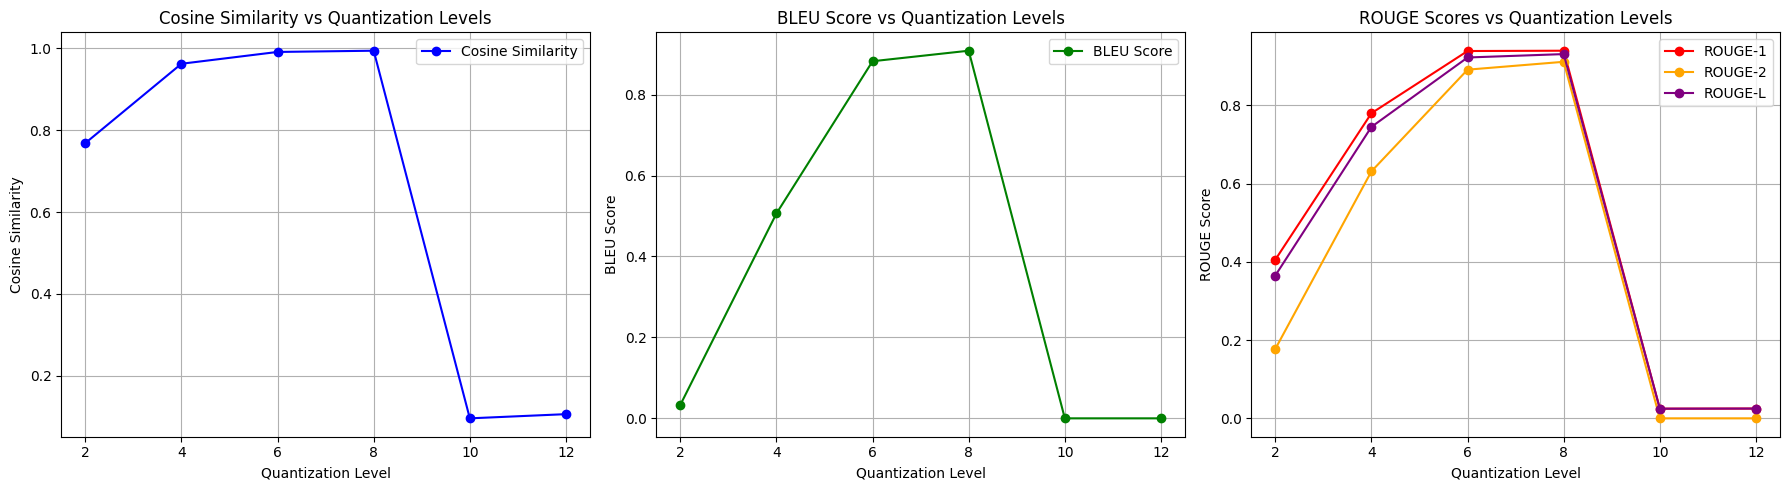

In [69]:
import matplotlib.pyplot as plt

bit_levels = [2, 4, 6, 8, 10, 12]

# Create plots
plt.figure(figsize=(18, 5))

# Cosine similarity plot
plt.subplot(1, 3, 1)
plt.plot(bit_levels, cosine_similarities, marker='o', color='b', label='Cosine Similarity')
plt.title('Cosine Similarity vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()

# BLEU score plot
plt.subplot(1, 3, 2)
plt.plot(bit_levels, bleu_scores, marker='o', color='g', label='BLEU Score')
plt.title('BLEU Score vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()

# ROUGE scores plot
plt.subplot(1, 3, 3)
plt.plot(bit_levels, rouge_1_scores, marker='o', color='r', label='ROUGE-1')
plt.plot(bit_levels, rouge_2_scores, marker='o', color='orange', label='ROUGE-2')
plt.plot(bit_levels, rouge_l_scores, marker='o', color='purple', label='ROUGE-L')
plt.title('ROUGE Scores vs Quantization Levels')
plt.xlabel('Quantization Level')
plt.ylabel('ROUGE Score')
plt.grid(True)
plt.legend()

# Show plots
plt.tight_layout()
plt.show()
